# Background

This notebook is to get the data ready for MatLab entropy script. According to the `apsamen_cleaned.m` script:

```MatLab
%%%%%%%%%%%%%%%%%%%%%%%%%%%%  CALCULATIONS  %%%%%%%%%%%%%%%%%%%%%%%%%%%%
for num=1:num_cols
    std1(num) = std(data1(N1:N2,num));
    avg1(num) = mean(data1(N1:N2,num));
    for n=1:4:10 % Different delay numbers n=1, 5, 9 ?? H.M.A. 08/23/2016
        % num = variable
        % 2 = dimension
        % 0.2*std1(num) = r (filter factor of variable)
        % n = delay number ( set to the smallest lag at which the
        %                   autocorrelation function of the time series is close to zero)
         [ap(n,num),  sam(n,num)]  = ApSamEn(data1(N1:N2,num),2,0.2*std1(num),n);
    end

  % p = pwelch(data1(N1:N2,num),{},1);
  % q = p./sum(p);
  % h = q.*log(1./q);

   % spec(num) = sum(h)/log(length(data1(N1:N2,num))); %
end
```

Dimension and r will stay as the default, the delay number needs to be found for each participant

In [1]:
def pub_theme(text_size):
    '''
    Ggplot theme to make graph ready for publishing.
    '''
    item = theme(
        # text settings
        text = element_text(size = text_size, ha='center',family='sans'),
        # plot_title = element_text(hjust = 0.5),
        # background color
        panel_background = element_rect(fill = 'white'),
        # border color
        panel_border = element_blank(),
        # axis settings
        axis_line = element_line(),
        axis_text_x = element_text(size = text_size*0.8, ha='center',family='sans'),
        axis_text_y = element_text(size = text_size*0.8, ha='right', family='sans'),
        # get rid of axis
        panel_grid_major_x = element_blank(),
        panel_grid_major_y = element_blank(),
        panel_grid_minor_x = element_blank(),
        panel_grid_minor_y = element_blank(),
        # legend settings
        legend_background = element_blank()
    )
    return item

In [2]:
save_plot = True

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as prog_bar
from icecream import ic

from statsmodels import api as sm # calculate ACF

In [4]:
joints = pd.read_csv('raw_data_merged/joints.csv')

In [5]:
# Create unique ID
joints['unique_id'] = joints['id'] + '_' + joints['date'] + '_' + joints['dance']
unique_id = list(joints['unique_id'].unique())
part = list(joints['id'].unique())

unique_id.sort()
part.sort()

# Rename IDs
new_id_map = {}
for p in part:
    sess_counter = 0
    for u in unique_id:
        if p in u:
            sess_counter += 1
            if sess_counter < 10:
                new_id_map[u] = f"{p}_record0{sess_counter}"
            else:
                new_id_map[u] = f"{p}_record1{sess_counter}"

In [6]:
def test_unique_id(dataframe):
    '''
    Tests that each participant has appropriate number of sessions
    '''
    answer = {
        'pddance001':2,
        'pddance002':8,
        'pddance003':2,
        'pddance005':3,
        'pddance006':4,
        'pddance007':4,
        'pddancecon001':2,
        'pddancecon002':2,
        'pddancecon003':3,
        'pddancecon004':3,
        'pddancecon005':2
    }
    
    id_test = dataframe.groupby('unique_id').count().reset_index()['unique_id'].str.split('_', expand=True)
    id_test.columns = ['id','record']
    res = id_test.groupby('id').count().reset_index()
    
    counter = 0
    for i, row in res.iterrows():
        if row['record'] == answer[row['id']]:
            counter +=1
    if counter == len(answer.keys()):
        return 'PASSED'
    else:
        return 'FAILED', res, counter

In [7]:
joints['unique_id'] = joints['unique_id'].map(new_id_map)
joints['record'] = joints['unique_id'].apply(lambda x: x.split('_')[1])
joints = joints.drop(['marker'], axis=1)

In [8]:
unique_id = joints.unique_id.unique()

In [9]:
test_unique_id(joints)

'PASSED'

In [10]:
# Check for NaN
joints.isna().sum()

id                                     0
date                                   0
dance                                  0
time                                   0
joints-elbow_lt-flexion_(deg)       1840
joints-hip_lt-flexion_(deg)          264
joints-hip_lt-abduction_(deg)        264
joints-hip_lt-rotation_ext_(deg)     264
joints-knee_lt-flexion_(deg)           0
joints-elbow_rt-flexion_(deg)       5868
joints-hip_rt-flexion_(deg)         3896
joints-hip_rt-abduction_(deg)       3896
joints-hip_rt-rotation_ext_(deg)    3896
joints-knee_rt-flexion_(deg)           0
dance_group                            0
group                                  0
unique_id                              0
record                                 0
dtype: int64

In [11]:
# Forward fill NaN
has_na = {}
joints_nona = pd.DataFrame()
for u in unique_id:
    temp = joints[joints['unique_id']==u]
    na_sum = temp.isna().sum().sum() # check whether any NaNs left

    if na_sum > 0:
        has_na[u] = temp
        
    joints_nona = joints_nona.append(temp)

list(has_na.keys())

['pddance006_record04',
 'pddancecon004_record03',
 'pddancecon004_record02',
 'pddancecon002_record01',
 'pddancecon002_record02',
 'pddancecon003_record02']

In [12]:
def fill_na_():
    '''
    Created when there were NaNs that had to be bfilled
    '''
    for key, value in has_na.items():
        na_series = value.isna().sum()
        print(f"{key} has {na_series.sum()} NaNs")
        cols = na_series[na_series > 0].index
        for col in cols:
            print(value[col].head(8))
    for key, value in has_na.items():
        value = value.fillna(method = 'bfill')
        has_na[key] = value
    # reintegrate the NaN datasets into main dataset, then recalc ACF
    new_joints = pd.DataFrame()
    for u in unique_id:
        if u not in has_na.keys():
            temp = joints[joints['unique_id'] == u]
        else:
            temp = has_na[u]
        new_joints = new_joints.append(temp)
    print(len(new_joints['id'].unique()) == len(joints['id'].unique()))

All `NaN` occurred in the first 4 rows. so we will just `bfill` those rows. Time series is still sequential.

In [13]:
joints_ = pd.DataFrame()

for rec in joints_nona['unique_id'].unique():
    temp = joints_nona[joints_nona['unique_id'] == rec]
    if rec in has_na.keys():
        temp = temp.fillna(method = 'bfill')
    joints_ = joints_.append(temp)

In [14]:
joints_.isna().sum()

id                                  0
date                                0
dance                               0
time                                0
joints-elbow_lt-flexion_(deg)       0
joints-hip_lt-flexion_(deg)         0
joints-hip_lt-abduction_(deg)       0
joints-hip_lt-rotation_ext_(deg)    0
joints-knee_lt-flexion_(deg)        0
joints-elbow_rt-flexion_(deg)       0
joints-hip_rt-flexion_(deg)         0
joints-hip_rt-abduction_(deg)       0
joints-hip_rt-rotation_ext_(deg)    0
joints-knee_rt-flexion_(deg)        0
dance_group                         0
group                               0
unique_id                           0
record                              0
dtype: int64

In [15]:
joints = joints_.copy()

In [16]:
# This function was copied from "02 eda.ipynb" notebook
def cat_dance(text):
    if ('tango' in text) | ('prominent' in text):
        return 'tango'
    elif ('waltz' in text):
        return 'waltz'
    # Dr. Ridgel confirmed boxstep fits with foxtrot
    elif ('foxtrot' in text) | ('boxstep' in text):
        return 'foxtrot'
    # electric slide is a type of line dance
    elif ('electric' in text) | ('line' in text):
        return 'line'
    elif ('swing' in text):
        return 'swing'
    elif 'rumba' in text:
        return 'rumba'
    else:
        return text

In [17]:
joints['dance_group'] = joints['dance'].apply(cat_dance)

In [18]:
joints = joints[(~joints['dance_group'].str.contains('swing')) & (~joints['dance_group'].str.contains('rumba'))]

# Time Plots

In [19]:
time = joints.copy()
# cleaner names
time.columns = [col.replace('joints-','').replace('_(deg)','') for col in joints.columns]

In [20]:
from plotnine import *

In [21]:
time['group'] = time['id'].apply(lambda x: 'OA' if 'cecon' in x else 'PD')

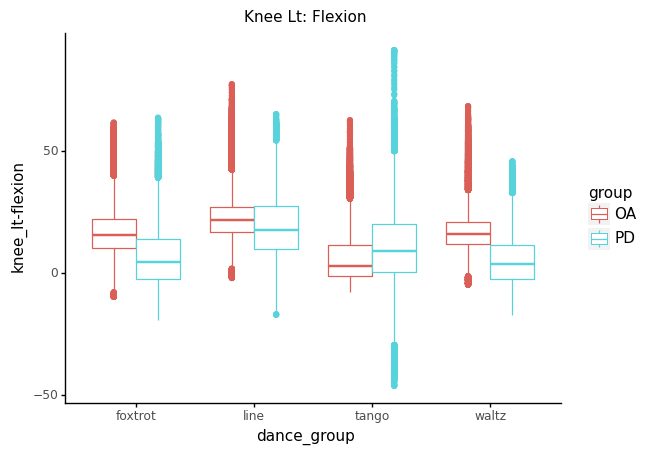

<ggplot: (8765668361463)>

In [22]:
y = 'knee_lt-flexion'
p = (
    ggplot(time, aes(x='dance_group',y=y,color='group')) +
    geom_boxplot(position='dodge') +
    pub_theme(11) +
    ggtitle(y.title().replace('_',' ').replace('-',': '))
)
p

# Finding lowest ACF at lowest lag

`Tau` is the name of the delay number in the `ApSamEn.m` script

[Source](https://qingkaikong.blogspot.com/2017/01/signal-processing-finding-periodic.html) for finding the ACF.

Process:

1. Calculate ACF
2. Isolate smallest lag number where the ACF is closest to 0

## Helper functions

### Lag finders

In [23]:
def get_acf_lag(my_series: pd.Series) -> pd.DataFrame:
    'Finds the ACF for a timeseries'
    # get ACF
    acf = sm.tsa.acf(my_series, nlags=len(my_series), fft=True)
    lag = np.arange(len(my_series))
    
    new_df = pd.DataFrame({
        'lag':list(lag),
        'acf':list(acf)
    })
    
    return new_df

In [24]:
def find_smallest_lag(dataframe: pd.DataFrame) -> list:
    '''
    Finds the smallest lag where ACF is closest to 0.
    
    input
    -----
    dataframe: a dataframe of all ACF and accompanying lag values for a given time series
    
    output
    ------
    smallest_lag: the first lag at which ACF was <= 0.1
    smallest_acf: the ACF values closest to 0 at the smallest lag
    '''
    smallest_acf = 1
    smallest_lag = 1
    
    res = dataframe[abs(dataframe['acf']) <= 0.1].head(50)
    for i, row in res.iterrows():
        acf = abs(row['acf'])
        lag = abs(row['lag'])
        if (acf < smallest_acf) & ((abs(smallest_lag - lag) <= 10) | (smallest_lag == 1)):
            smallest_acf = acf
            smallest_lag = lag
    return smallest_lag, smallest_acf

In [25]:
def acf_brain(mainframe: pd.DataFrame, measure: str) -> list:
    '''
    Runs for loop on dataframe to find the ACF closest to 0 at the smallest 
    possible lag for each unique recording of a given measure.
    
    NaNs are ffilled.
    
    mainframe: pd.DataFrame
        Dataframe that includes all participants, variables, dances
    measure: str
        Time series column from mainframe 
    '''
    
    # initiate dataframe
    all_acf = pd.DataFrame()
    tau_results_mini = pd.DataFrame()
    
    # for each unique recording find and append the smallest lags
    for uni in prog_bar(mainframe['unique_id'].unique()):
        # extract unique recording from main dataframe (joints)
        temp_df = mainframe[(mainframe['unique_id']==uni)]
        part = temp_df['id'].unique()[0]
        dance = temp_df['dance'].unique()[0]
        date = temp_df['date'].unique()[0]
        record = uni.split('_')[1]
        
        # isolate time_series
        temp = temp_df[measure]

        acf_df = get_acf_lag(temp) # get dataframe of acf-lag
        smol_lag, smol_acf = find_smallest_lag(acf_df) # extract smallest acf at smallest lag
        res = pd.DataFrame({
            'id':[part],
            'unique_id':[uni],
            'record':[record],
            'dance':[dance],
            'date':[date],
            'lag':[smol_lag],
            'acf':[smol_acf]
        })
        acf_df['id'] = part
        acf_df['unique_id'] = uni
        acf_df['record'] = record
        acf_df['dance'] = dance
        acf_df['date'] = date

        all_acf = all_acf.append(acf_df)
        tau_results_mini = tau_results_mini.append(res)

    tau_results_mini = tau_results_mini.reset_index(drop=True)
    
    # differentiate pd from oa
    tau_results_mini['group'] = tau_results_mini['id'].apply(lambda x: 'oa' if 'cecon' in x else 'pd')
    # categorize dances
    tau_results_mini['dance_group'] = tau_results_mini['dance'].apply(cat_dance)
    all_acf = all_acf.reset_index(drop=True)   
    all_acf['dance_group'] = all_acf['dance'].apply(cat_dance)
    
    return tau_results_mini, all_acf

### Plotters

In [26]:
def plot_acf_dance(dataframe, measure):
    '''
    Plots two swarmplots side by side, one with ACF and the other with Lag on y axis.
    X axis is dance, hue is pd/oa.
    
    dataframe: pd.Dataframe
        Dataframe with "acf" and "lag" columns, obtained from acf_brain()
    '''
    fig, ax = plt.subplots(ncols=2, figsize=(12,4))
    measure = measure.replace('_',' ').title()
    
    for i in [0,1]:
        if i == 0:
            lim = (-0.02, 1)
            box = (2,1)
            sns.stripplot(x='dance_group', y='acf', data=dataframe, hue='group', ax=ax[i])
            ax[i].set_title(f'ACFs closest to zero at smallest lag by dance')
            ax[i].text(3,0.125,measure,)
            ax[i].set_ylabel('ACF')
        else:
            lim = (0,max(dataframe['lag']) + 60)
            box = (1.35,1)
            sns.stripplot(x='dance_group', y='lag', data=dataframe, hue='group', ax=ax[i], alpha=1)
            ax[i].set_title(f'Smallest lags with smallest ACFs by dance')
            ax[i].set_ylabel('Lag')
        ax[i].legend(bbox_to_anchor=box)
        ax[i].set_xlabel('Dance')
        ax[i].set_ylim(lim)

In [27]:
from plotnine import *

def pub_theme(text_size):
    '''
    Ggplot theme to make graph ready for publishing.
    '''
    item = theme(
        # text settings
        text = element_text(size = text_size, ha='center',family='sans'),
        # plot_title = element_text(hjust = 0.5),
        # background color
        panel_background = element_rect(fill = 'white'),
        # border color
        panel_border = element_blank(),
        # axis settings
        axis_line = element_line(),
        axis_text_x = element_text(size = text_size*0.8, ha='center',family='sans'),
        axis_text_y = element_text(size = text_size*0.8, ha='right', family='sans'),
        # get rid of axis
        panel_grid_major_x = element_blank(),
        panel_grid_major_y = element_blank(),
        panel_grid_minor_x = element_blank(),
        panel_grid_minor_y = element_blank(),
        # legend settings
        legend_background = element_blank()
    )
    return item

def pub_scatter(name):
    '''
    Adds scatterplot to ggplot with default point shapes.
    For more point options see: https://matplotlib.org/stable/api/markers_api.html
    
    name: title of legend
    '''

    
    
    return s, c

## Calculate

In [28]:
all_measures = [col for col in joints.columns if 'joints' in col]

In [29]:
tau_results_dict = {}
all_acfs_dict = {}
for m in prog_bar(all_measures):
    res = acf_brain(joints, m)
    tau_results_dict[m] = res[0]
    all_acfs_dict[m] = res[1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [30]:
tau_results_df = pd.DataFrame()
for k,v in tau_results_dict.items():
    v['measure'] = k
    tau_results_df = tau_results_df.append(v)
tau_results_df = tau_results_df.reset_index(drop=True)

In [31]:
tau_results_df = tau_results_df.drop(['dance'], axis =1)

In [32]:
melt = tau_results_df.melt(id_vars = ['id','date','group','dance_group','measure'])

In [33]:
melt.head()

,id,date,group,dance_group,measure,variable,value
0,pddancecon005,2018-11-15 13:47:00,oa,line,joints-elbow_lt-flexion_(deg),unique_id,pddancecon005_record01
1,pddancecon005,2018-11-15 14:04:00,oa,line,joints-elbow_lt-flexion_(deg),unique_id,pddancecon005_record02
2,pddance006,2018-12-08 12:15:00,pd,foxtrot,joints-elbow_lt-flexion_(deg),unique_id,pddance006_record02
3,pddance006,2018-12-08 12:07:00,pd,foxtrot,joints-elbow_lt-flexion_(deg),unique_id,pddance006_record01
4,pddance006,2018-12-08 12:30:00,pd,tango,joints-elbow_lt-flexion_(deg),unique_id,pddance006_record04


## Plot smallest ACFs

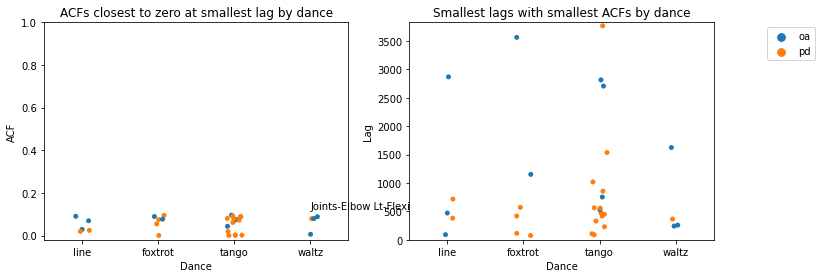

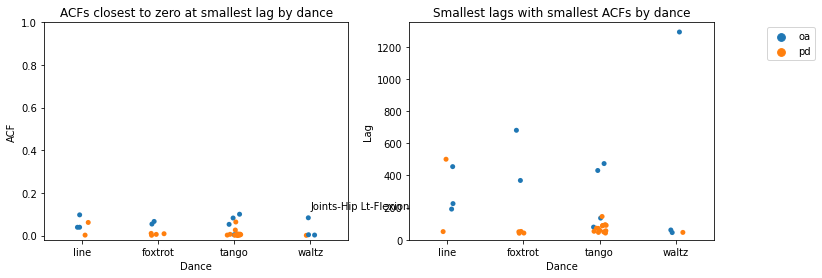

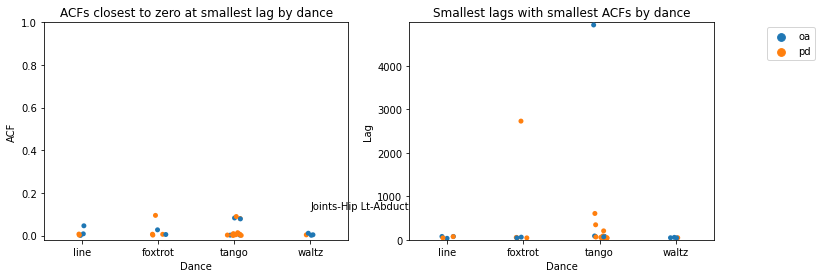

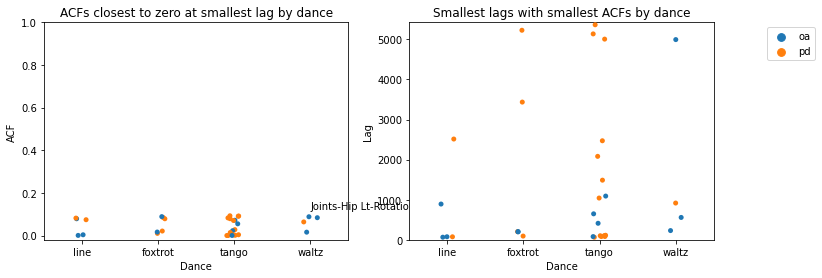

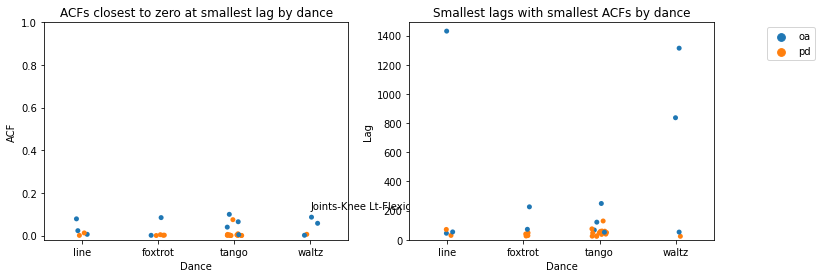

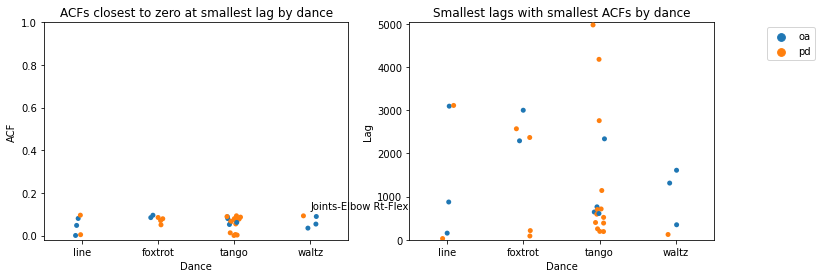

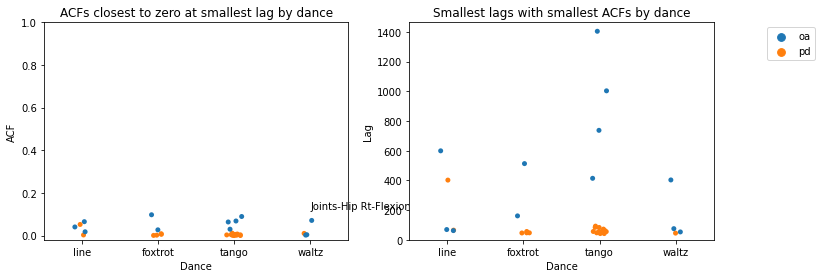

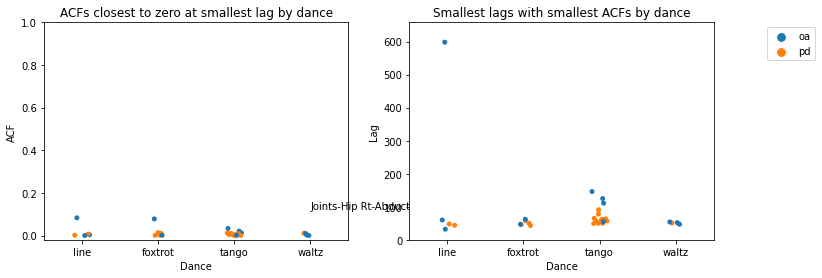

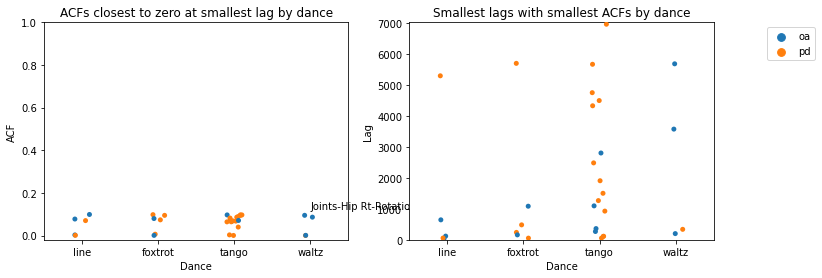

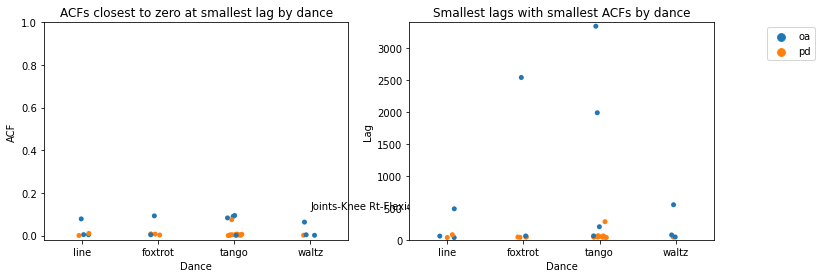

In [34]:
for key,value in tau_results_dict.items():
    plot_acf_dance(tau_results_dict[key], key)

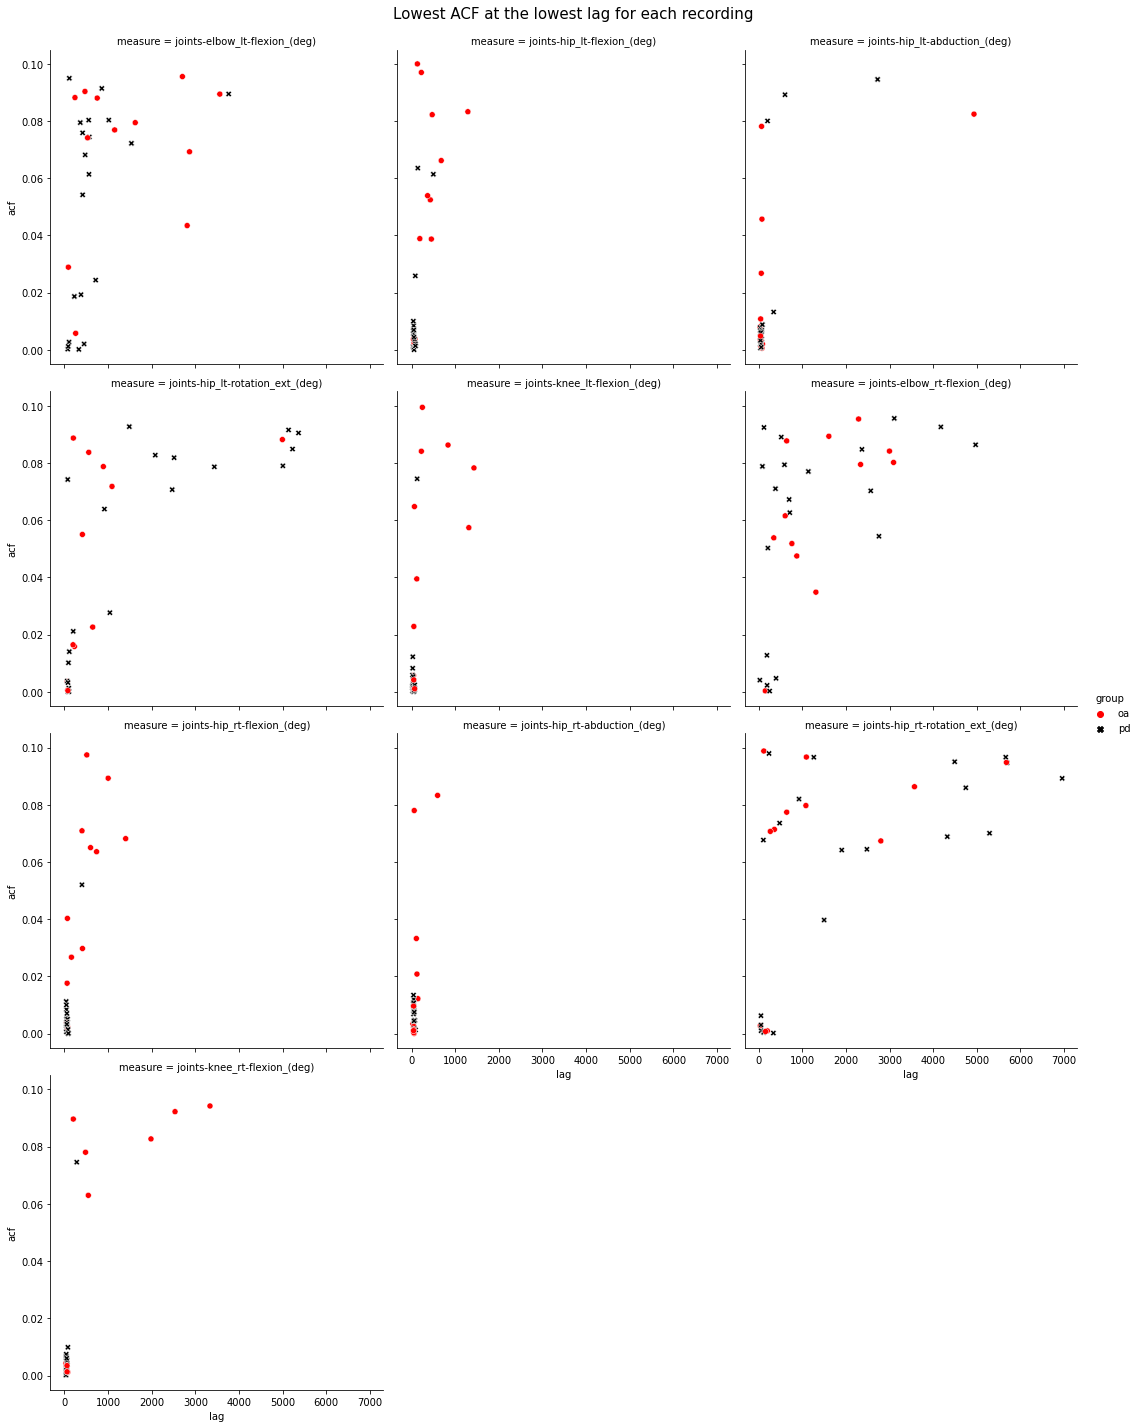

In [35]:
palette_2d = ['red','black']
g = sns.relplot(x='lag',y='acf',data=tau_results_df, col='measure',col_wrap=3,
                style='group', hue='group', palette=palette_2d)
g.fig.suptitle('Lowest ACF at the lowest lag for each recording', size=15)
g.fig.subplots_adjust(top=0.95)

In [36]:
tau_results_df.groupby('group').describe()

lag                                                               \
       count        mean          std   min    25%    50%     75%     max   
group                                                                       
oa     120.0  753.716667  1130.054406  32.0  67.75  236.0  846.50  5679.0   
pd     200.0  660.490000  1373.466410  24.0  48.75   71.5  405.75  6957.0   

         acf                                                              \
       count      mean       std       min       25%       50%       75%   
group                                                                      
oa     120.0  0.046997  0.036377  0.000082  0.004075  0.053131  0.082270   
pd     200.0  0.027135  0.034658  0.000004  0.002081  0.006298  0.064246   

                 
            max  
group            
oa     0.099972  
pd     0.097946

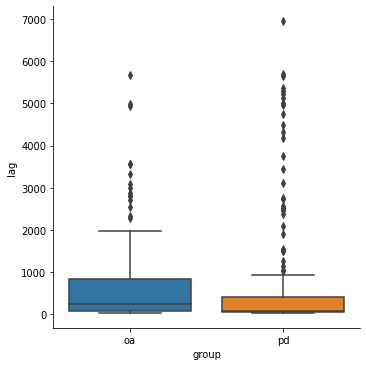

In [37]:
sns.catplot(x='group',y='lag', data=tau_results_df, kind = 'box')

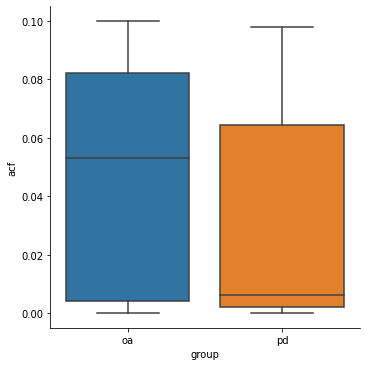

In [38]:
sns.catplot(x='group',y='acf', data=tau_results_df, kind = 'box')

### Find the baddies

An ACF of 1 should not exist in our dataset

In [39]:
bad = pd.DataFrame()
for i, row in tau_results_df.iterrows():
    if row['acf'] > 0.1:
        bad = bad.append(row)

In [40]:
bad

""


the bug was fixed!

Turns out NaNs were never filled.

## Plot all ACFs

ACF plots for all recordings, also to see whether anything weird is going on with the baddies

In [41]:
all_acfs_df = pd.DataFrame()
for k,v in prog_bar(all_acfs_dict.items()):
    v['measure'] = k
    all_acfs_df = all_acfs_df.append(v)

  0%|          | 0/10 [00:00<?, ?it/s]

In [42]:
all_acfs_df = all_acfs_df.reset_index(drop=True)

In [43]:
all_acfs_df = all_acfs_df.sort_values(['unique_id','measure','lag'])

In [48]:
# Save as pickle to avoid running entire notebook each time
# all_acfs_df.to_pickle('all_acfs_df.pickle')
# tau_results_df.to_pickle('tau_results_df.pickle')

In [5]:
sns.set(font_scale=1.5)
sns.set_style(style='white')

In [6]:
def plot_zooms(dataframe: pd.DataFrame, smallest_lags: pd.DataFrame, fig, ax) -> None:
    '''
    Plots 4 subplots, each zoomed more and more in. Requires both dataframe to 
    be filtered for measures.
    
    dataframe: df of all acfs/lags for one participant
    smallest_lags: df of all participants' smallest acfs at smallest lags
    '''
    letters = ['A', 'B']
    row_ax = 0 # for axis
    for num in range(len(dataframe['measure'].unique())):
        m = dataframe['measure'].unique()[num]
        letter = letters[num]
        for u in dataframe['unique_id'].unique():
            relevant_tau = tau_results_df[tau_results_df['measure'] == m]
            temp_df = dataframe[(dataframe['unique_id'] == u) & (dataframe['measure'] == m)]
            size = len(temp_df)
            row = smallest_lags[(smallest_lags['unique_id']==u) & (smallest_lags['measure']==m)]
            ic(u, m)
            acf = row['acf']
            lag = row['lag']
            dance = list(temp_df['dance_group'].unique())[0]
            part = list(temp_df['id'].unique())[0]

            for i in [0,1,2,3]: # columns
                ax[row_ax,i].plot(temp_df['lag'], temp_df['acf'], c='black')
                ax[row_ax,i].scatter(lag, acf, c='red')
                ax[row_ax,i].set_xlabel('Lags')
                ax[row_ax,i].set_ylabel('Autocorrelation')
                ax[row_ax,i].axhline(y=0,xmin=0,xmax=3,c="red",linestyle=':')
                if i == 0:
                    ax[row_ax,i].set_title('Full view')
                    if row_ax == 0: # add "A" label
                        ax[row_ax,i].text(x,y,letter, fontsize=22.0, fontweight='bold')
                    elif row_ax == 2: # add "B" label
                        ax[row_ax,i].text(x,y,letter, fontsize=22.0, fontweight='bold')
                if i == 1:
                    ax[row_ax,i].set_xlim(0, int(size*0.5))
                    ax[row_ax,i].set_title('50% view')
                elif i == 2:
                    ax[row_ax,i].set_xlim(0, int(size*0.25))
                    ax[row_ax,i].set_title('25% view')
                elif i == 3:
                    ax[row_ax,i].set_xlim(0, int(size*0.05))
                    ax[row_ax,i].set_title('5% view')
            # build caption
            caption = ''
            if 'cecon' in u:
                caption += '[OA]'
            else:
                caption += '[PD]'

            u = u.replace('_',': ')
            caption += f' {u}'

            ax[row_ax,i].text(x,y,caption)
            row_ax += 1
    return fig, ax

ic| u: 'pddance003_record01', m: 'joints-knee_lt-flexion_(deg)'
ic| u: 'pddancecon003_record03', m: 'joints-knee_lt-flexion_(deg)'
ic| u: 'pddance003_record01', m: 'joints-knee_rt-flexion_(deg)'
ic| u: 'pddancecon003_record03', m: 'joints-knee_rt-flexion_(deg)'
ic| 'Saving the figure'


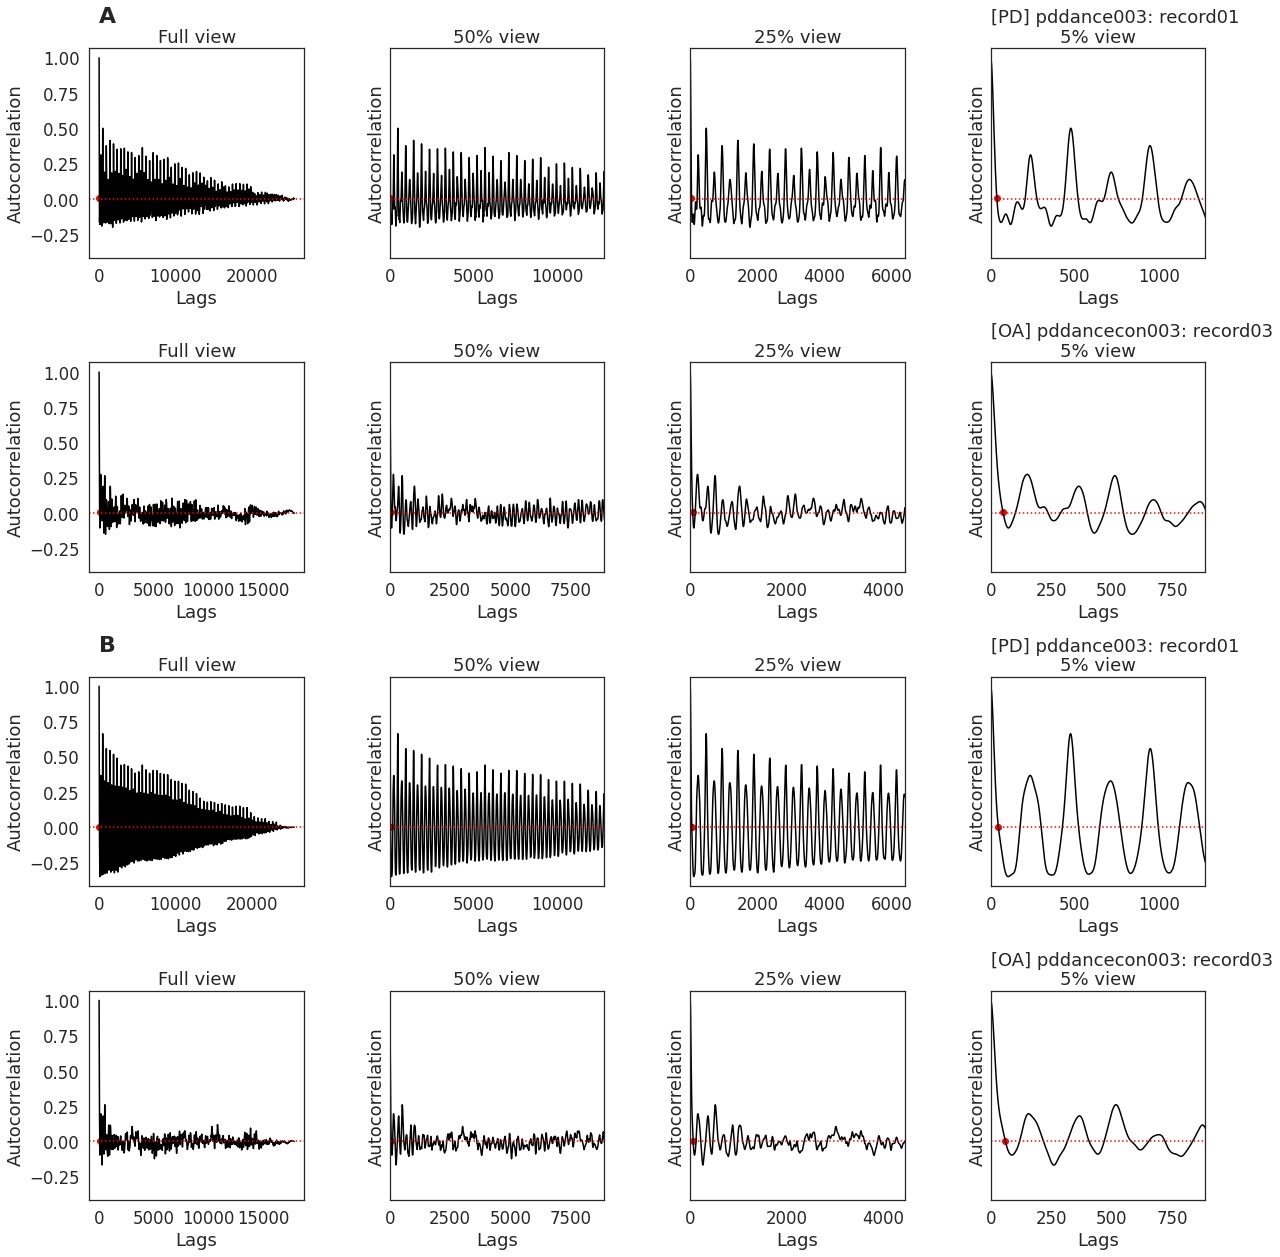

In [8]:
if True:
    # Save two sample plots as png
    all_acfs_df = pd.read_pickle('all_acfs_df.pickle')
    tau_results_df = pd.read_pickle('tau_results_df.pickle')
    x=0
    y=1.25
    plot_acfs_df = all_acfs_df[((all_acfs_df['unique_id'] == 'pddance003_record01') | (all_acfs_df['unique_id'] == 'pddancecon003_record03')) & (all_acfs_df['dance_group'] == 'tango')]
    plot_acfs_df = plot_acfs_df[plot_acfs_df['measure'].str.contains('knee')]
    # initiate grid
    fig, ax = plt.subplots(nrows=4, ncols=4, sharey=True, figsize = (20,20))
    fig, ax = plot_zooms(plot_acfs_df,tau_results_df, fig, ax)
    
    fig.subplots_adjust(top = 0.90, bottom=0.10, hspace=0.5, wspace=0.4)
    ic("Saving the figure")
    fig.savefig('figures/figure4.jpeg', dpi=500)

In [66]:
if save_plot:
    # Save all plots into PDFs
    from matplotlib.backends.backend_pdf import PdfPages # save to pdf
    x=0
    y=1.19
    for m in prog_bar(all_acfs_df['measure'].unique()):
        with PdfPages(f'figures/all_acf_plots/acf_plots_{m}.pdf') as pdf_pages:
            for u in prog_bar(all_acfs_df['unique_id'].unique()):
                # We had bug because the all measure's tau was sent to plotter
                relevant_tau = tau_results_df[tau_results_df['measure'] == m]
                temp_df = all_acfs_df[(all_acfs_df['unique_id'] == u) & (all_acfs_df['measure'] == m)]
                fig, ax = plot_zooms(temp_df, relevant_tau)

                dance = list(temp_df['dance_group'].unique())[0]
                part = list(temp_df['id'].unique())[0]

                # build caption
                caption = ''
                if 'cecon' in u:
                    caption += 'OA'
                else:
                    caption += 'PD'

                caption += f'_{u}'

                plt.text(x,y,caption)
                pdf_pages.savefig(fig)

### Test calculations

In [67]:
def test_acf_lag(acf_series, raw_series):
    '''
    Tests that the lag/acf are correct
    
    acf_series: pd.DataFrame
        The current acf calculations, with 'acf' col
    raw_series: pd.DataFrame
        The time series to caclulate acf from
    '''
    acf_series = acf_series.reset_index(drop = True)
    acf_answ = get_acf_lag(raw_series)
    try:
        num_good = (acf_answ['acf'] == acf_series).sum()
    except:
        return acf_answ, acf_series
    
    if num_good == len(acf_series):
        return True
    else:
        return False

In [ ]:
### all_parts = joints['unique_id'].unique()
all_measures = [col for col in joints.columns if 'joints' in col]
all_records = list(joints['unique_id'].unique())

num_uni = len(all_records)

for m in prog_bar(all_measures):
    counter = 0
    failed_uniques = []
    for uni in prog_bar(all_records):
        # extract each record
        test_acf_df = all_acfs_df[(all_acfs_df['unique_id']==uni) & (all_acfs_df['measure']==m)]
        # extract raw measure of same record
        test_raw_df = joints[joints['unique_id']==uni]
        if (test_acf_df.empty) | (test_raw_df.empty):
            print(f"EMPTY: {uni} | {m}")
            continue
        else:
            test_acf = test_acf_df['acf']
            test_raw = test_raw_df[m]
        if test_raw.isna().sum() > 0:
            print(f'NANS DETECTED IN RAW SERIES ({round(test_raw.isna().sum()/len(test_raw),4) * 100}%) | {uni} | {m}')
            test_raw = test_raw.fillna(method='ffill')
            if test_raw.isna().sum() > 0:
                print('NaN still there. Trying bfill.')
                test_raw = test_raw.fillna(method='bfill')
            if test_raw.isna().sum() > 0:
                print('NaN DID NOT GET FILLED')
                continue
        try:
            # run through test, add if successful
            res = test_acf_lag(test_acf, test_raw)
            counter+=res
            if not res:
                failed_uniques.append(uni)
        except:
            print(uni, m)
    if counter == num_uni: # then they all passed
        print(f'PASSED: {m}')

    else:
        print(f'FAILED: {round((counter/num_uni)*100,1)}% passed {m}')
        print(failed_uniques)

In [63]:
def select_record(dataframe, record):
    return dataframe[dataframe['unique_id'] == record]

# Tau Stats

In [69]:
tau_results_df.head()

,id,unique_id,record,date,lag,acf,group,dance_group,measure
0,pddancecon005,pddancecon005_record01,record01,2018-11-15 13:47:00,471.0,0.090340,oa,line,joints-elbow_lt-flexion_(deg)
1,pddancecon005,pddancecon005_record02,record02,2018-11-15 14:04:00,2867.0,0.069245,oa,line,joints-elbow_lt-flexion_(deg)
2,pddance006,pddance006_record02,record02,2018-12-08 12:15:00,570.0,0.074428,pd,foxtrot,joints-elbow_lt-flexion_(deg)
3,pddance006,pddance006_record01,record01,2018-12-08 12:07:00,418.0,0.054206,pd,foxtrot,joints-elbow_lt-flexion_(deg)
4,pddance006,pddance006_record04,record04,2018-12-08 12:30:00,475.0,0.068155,pd,tango,joints-elbow_lt-flexion_(deg)


In [70]:
tau_results_df['joint'] = tau_results_df['measure'].str.extract('joints-([a-z]\w+)_')
tau_results_df['side'] = tau_results_df['measure'].str.extract('joints-[a-z]\w+_([a-z]\w+)')
tau_results_df['movement'] = tau_results_df['measure'].str.extract('joints-[a-z]\w+_[a-z]\w+-([a-z]\w+)_?')

In [71]:
for col in ['joint','side','movement']:
    tau_results_df[col] = tau_results_df[col].str.strip('_')
    print(tau_results_df[col].unique())

['elbow' 'hip' 'knee']
['lt' 'rt']
['flexion' 'abduction' 'rotation_ext']


In [72]:
tau_results_df['joint_move'] = tau_results_df['joint'] + '_' + tau_results_df['movement']

In [73]:
tau_means = tau_results_df.groupby(['group','joint_move']).mean().reset_index()
#tau_means = tau_means.melt(id_vars = ['group','joint_move'])

In [74]:
tau_means

,group,joint_move,lag,acf
0,oa,elbow_flexion,1420.791667,0.066467
1,oa,hip_abduction,291.583333,0.021331
2,oa,hip_flexion,413.791667,0.049887
3,oa,hip_rotation_ext,1061.333333,0.053050
4,oa,knee_flexion,581.083333,0.044248
5,pd,elbow_flexion,963.350000,0.054161
6,pd,hip_abduction,147.125000,0.011648
7,pd,hip_flexion,81.075000,0.008737
8,pd,hip_rotation_ext,2057.650000,0.054230
9,pd,knee_flexion,53.250000,0.006897


Text(0.5, 1.05, 'Lag values by dance type')

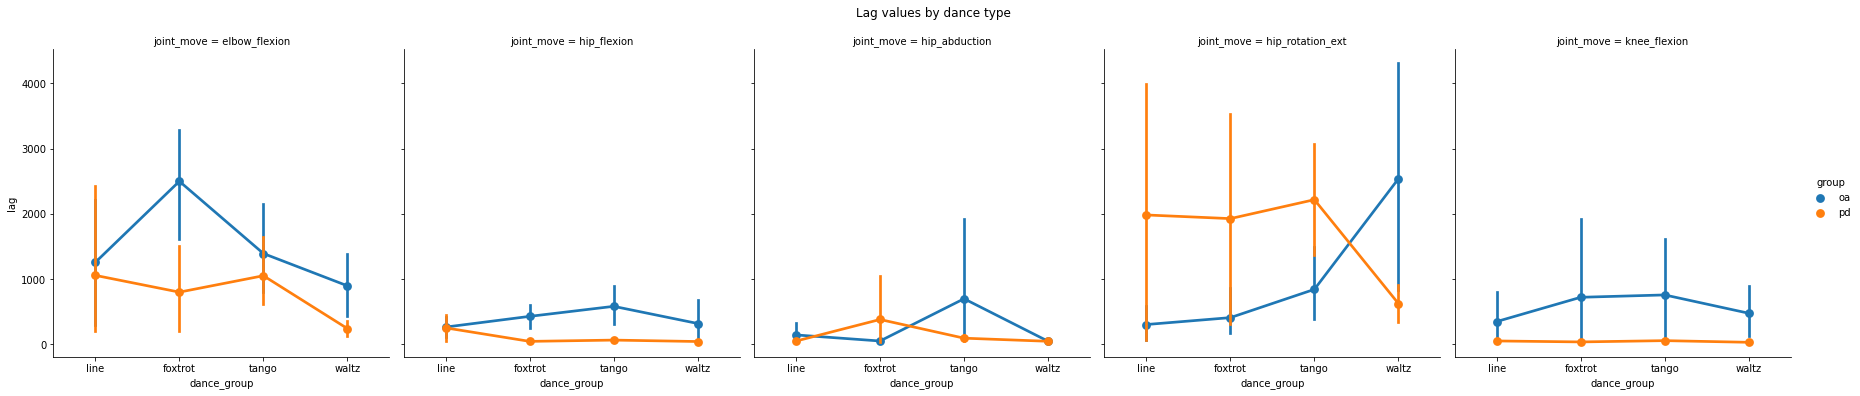

In [75]:
sns.catplot(x='dance_group',y='lag',col='joint_move', data=tau_results_df, kind='point', hue = 'group')
plt.suptitle("Lag values by dance type", y=1.05)

Text(0.5, 1.05, 'ACF values by dance type')

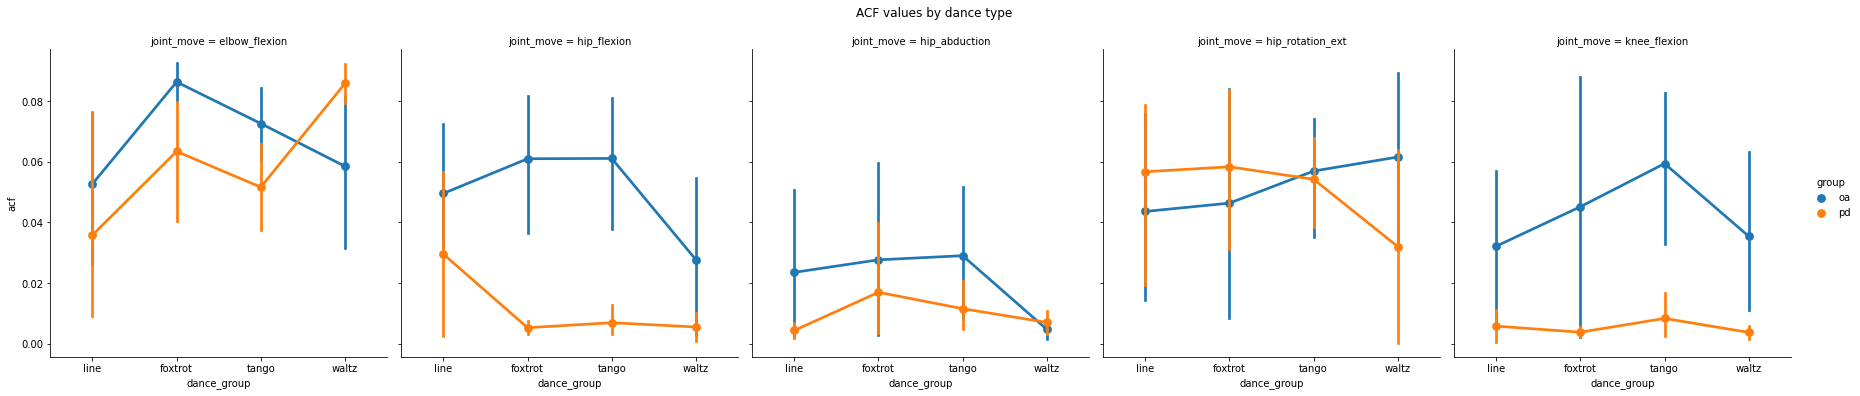

In [102]:
sns.catplot(x='dance_group',y='acf',col='joint_move', data=tau_results_df, kind='point',  hue = 'group')
plt.suptitle("ACF values by dance type", y=1.05)

In [78]:
tau_means.pivot(columns=['group','joint_move'], index='variable')

value                                             \
group                 oa                                              
joint_move elbow_flexion hip_abduction hip_flexion hip_rotation_ext   
variable                                                              
acf             0.066467      0.021331    0.049887         0.053050   
lag          1420.791667    291.583333  413.791667      1061.333333   

                                                                 \
group                              pd                             
joint_move knee_flexion elbow_flexion hip_abduction hip_flexion   
variable                                                          
acf            0.044248      0.054161      0.011648    0.008737   
lag          581.083333    963.350000    147.125000   81.075000   

                                          
group                                     
joint_move hip_rotation_ext knee_flexion  
variable                                  
acf                 0.05423     0.006897  
lag              2057.65000    53.250000

# Export Tau for MatLab

In [47]:
# tau_results_df.to_csv('raw_data_merged/tau_values.csv', index = False)

In [105]:
def save_to_excel(combined_df, lag_results, filetype = 'xlsx', measure = 'joints'):
    '''
    Saves all unique raw and acf records in dataframes to separate
    xlsx files for the entropy matlab script.
    
    Time column will be removed from the raw recordings, would make
    MatLab more complicated.
    
    NOTE: MatLab assumes name of lag_data and time_series files are identical 
    but in different folders
    
    input
    -----
    combined_df: pd.DataFrame
        df of all participants' records from noraxon
    lag_results: pd.DataFrame
        df of participants' smallest acf at smallest lags for each movement type
    filetype: str
        'xlsx' or 'csv'. XLSX filetype takes a long time to save (3 minutes), but is compatible with
        MatLab script. CSV filetype takes seconds.
    measure: str
        Unique word in columns of interest in 'combined_df'. Ex: 'joints'
    '''
    matlab = combined_df.drop(['dance','date','time'], axis=1)
    j_col = [col for col in matlab.columns if measure in col]
    base_cols = ['id','record','unique_id','dance_group']
    cols = base_cols + j_col

    for part in prog_bar(matlab['unique_id'].unique()):
        raw = matlab[matlab['unique_id'] == part]
        raw = raw[cols].drop(['id','record'], axis=1)

        acf_lag = lag_results[lag_results['unique_id'] == part]
        acf_lag = acf_lag[['unique_id','lag','acf','measure']]
        
        save_time = f"matlab_input/time_series/{part}"
        save_acf = f"matlab_input/lag_data/{part}"
        if filetype == 'xlsx':
            raw.to_excel(f"{save_time}.xlsx", index=False)
            acf_lag.to_excel(f"{save_acf}.xlsx", index=False)
        elif filetype == 'csv':
            raw.to_csv(f"{save_time}.csv", index=False)
            acf_lag.to_csv(f"{save_acf}.csv", index=False)
        else:
            print("Invalid filetype. Must be xlsx or csv")
            return None

In [104]:
# save_to_excel(joints, tau_results_df)

  0%|          | 0/32 [00:00<?, ?it/s]